In [0]:
# Use this if you want to mount the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from torch.nn import functional as F

In [0]:
#Original network
class SolarNet(Dataset):
    def __init__(self,i,l,r):
        self.images=i
        self.targets=l
        self.feats=r

    def __getitem__(self, index):
        item = {'image': self.images[index], 'power': self.targets[index], 'feats': self.feats[index]}
        return item
    
    def __len__(self):
        return self.images.shape[0]

class ImpactNet_A(nn.Module):
  def __init__(self):
    super().__init__()
    #Define dissembled operators
    self.dropout = nn.Dropout(p=0.5)
    self.relu=nn.ReLU()
    self.conv1=nn.Conv2d(3,16,7,padding=3)
    self.pool=nn.AvgPool2d(3)
    #AU1
    self.rcu1_conv=nn.Conv2d(16,32,1,2)
    self.rcu1=nn.Sequential(
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32)
        )
    #AU2
    self.rcu2_conv=nn.Conv2d(32,48,1,2)
    self.rcu2=nn.Sequential(
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48),
        nn.ReLU(),
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48)
        )
    #AU3
    self.rcu3_conv=nn.Conv2d(48,64,1,2)
    self.rcu3=nn.Sequential(
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64)
        )
    #AU4
    self.rcu4_conv=nn.Conv2d(64,80,1,2)
    self.rcu4=nn.Sequential(
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80)
        )
    #AU5
    self.rcu5_conv=nn.Conv2d(80,96,1,2)
    self.rcu5=nn.Sequential(
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96)
        )
    #FCs in Analysis unit part
    self.fu=nn.Linear(384,96)
    self.fc0=nn.Linear(96,96)

    #FC layers
    self.fc1=nn.Linear(4,64)
    self.fc2=nn.Linear(64,96)
    self.fc3=nn.Linear(192,32)
    self.fc4=nn.Linear(32,8)

  def forward(self,au,ef):
    #AU is output from images, EF is output from environment factors

    #Analysis network
    au=self.conv1(au)#1st layer: only conv2d
    au=self.relu(self.rcu1_conv(au)+self.rcu1(self.rcu1_conv(au)))#2nd layer: residual convolution unit
    au=self.relu(self.rcu2_conv(au)+self.rcu2(self.rcu2_conv(au)))#3rd layer: residual convolution unit
    au=self.relu(self.rcu3_conv(au)+self.rcu3(self.rcu3_conv(au)))#4th layer: residual convolution unit
    au=self.relu(self.rcu4_conv(au)+self.rcu4(self.rcu4_conv(au)))#5th layer: residual convolution unit
    au=self.relu(self.rcu5_conv(au)+self.rcu5(self.rcu5_conv(au)))#6th layer: residual convolution unit
    au=self.pool(au)#7th layer: maxpool 2d
    au=au.view(au.shape[0],-1)
    au=self.relu(self.dropout(self.fu(au)))
    au=self.relu(self.dropout(self.fc0(au)))

    #Fully Connect network
    ef=self.relu(self.dropout(self.fc1(ef)))
    ef=self.relu(self.dropout(self.fc2(ef)))
    
    o=torch.cat((ef,au),1)
    o=self.relu(self.dropout(self.fc3(o)))
    o=self.fc4(o)

    return o

In [0]:
#load data
def load_pic():
    """
    Load pictures
    Shape: (45754, 3, 192, 192)--(Batch size, Channel, Height, Width)
    """
    return np.load('drive/My Drive/nus/image.npy',mmap_mode='r')

def load_label():
    """
    Load power loss
    Shape: (45754,)--(Batch size)
    """
    return np.load('drive/My Drive/nus/label.npy',mmap_mode='r')

def load_feats():
    """
    Load environmental features
    Shape:(45754,4)--(Batch size,(Hour,Min,Sec,Irradiance level))
    """
    return np.load('drive/My Drive/nus/feats.npy',mmap_mode='r')

def load_all():
    """
    Load images, power loss and environmental features individually
    Return:
        images: Solar panel images
        Power_loss: %age power_loss of the panel with respect to the clean panel
        feats: environmental features
    """
    images=load_pic().transpose((0,3,1,2))
    Power_loss=load_label()
    feats=load_feats()
    return images,Power_loss,feats

def load_set():
    """
    Load the data as datasets
    Return:
        d_train: train set, includes 27537 data
        d_test: test set, includes 18217 data
    """
    i,l,r=load_all()
    print('Load all')
    """
    indt=np.random.randint(45754,size=9108)
    indd=np.random.randint(45754,size=9108)
    indr=np.random.randint(45754,size=27537)
    """
    index=np.array(list(range(45754)))
    np.random.shuffle(index)
    indt=index[36645:]
    indd=index[27537:36645]
    indr=index[:27537]
    print('begin random')
    d_train=SolarNet(i[indr],l[indr],r[indr])
    d_test=SolarNet(i[indt],l[indt],r[indt])
    d_dev=SolarNet(i[indd],l[indd],r[indd])
    return d_train,d_test,d_dev

In [0]:
def error(net,test,etype='L1'):
  j=0
  loss=0
  for data in test:
    j+=1
    i,p,f=torch.FloatTensor(data['image']).view(-1,3,192,192).cuda(),torch.FloatTensor([data['power']]).cuda(),torch.FloatTensor(data['feats']).view(1,-1).cuda()
    out=net(i,f)
    _,out=torch.max(out.data,1)
    if etype=='L1':
      loss+=torch.abs((out*12.5+6.25)-p)
    elif etype=='MSE':
      loss+=((out*12.5+6.25)-p)**2
    elif etype=='BE':
      p=(p*100//12.5).long()
      if p!=out:
        loss+=1
  return loss/j

def qrloss(net,test):
  j=0
  loss=0
  for data in test:
    j+=1
    i,p,f=torch.FloatTensor(data['image']).view(-1,3,192,192).cuda(),torch.FloatTensor([data['power']]),torch.FloatTensor(data['feats']).view(1,-1).cuda()
    out=net(i,f).squeeze().cpu()
    qg=torch.sort(F.softmax(out,dim=0))[0]
    s=0
    for i in range(len(qg)):
      s+=qg[i]
      qg[i]=s
    qg=qg.unsqueeze(0)
    y_true=(torch.ones(8)*p)
    y_pred=torch.FloatTensor([12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0])
    e=(y_true-y_pred)
    temp=torch.cat((qg*e,(qg-1)*e))
    temp=torch.max(temp,dim=0)[0]
    loss+=torch.mean(temp)
  return loss/j

def train_loss(net,train):
  j=0
  loss=0
  im,p,f=train['image'].float().cuda(),train['power'],train['feats'].float().cuda()
  for ind in range(im.shape[0]):
    j+=1
    image=im[ind].view(-1,3,192,192).cuda()
    factor=f[ind].view(1,-1).cuda()
    power=p[ind]
    out=net(image,factor).squeeze().cpu()
    qg=torch.sort(F.softmax(out,dim=0))[0]
    s=0
    for i in range(len(qg)):
      s+=qg[i]
      qg[i]=s
    qg=qg.unsqueeze(0)
    y_true=(torch.ones(8)*power)
    y_pred=torch.FloatTensor([12.5,25.0,37.5,50.0,62.5,75.0,87.5,100.0])
    e=(y_true-y_pred)
    temp=torch.cat((qg*e,(qg-1)*e))
    temp=torch.max(temp,dim=0)[0]
    loss+=torch.mean(temp)
  return loss/j
    

In [0]:
train,test,dev=load_set()
train_dataloader=DataLoader(train, 32)

Load all
begin random


In [0]:
#Original network experiment
from tqdm import tqdm
import matplotlib.pyplot as plt

#train Resnet
epochs=90
lr=0.00001

belos=[]
mselos=[]
l1los=[]
qrlos=[]
net=ImpactNet_A()
net.cuda()
criteria=nn.CrossEntropyLoss()
for ii in tqdm(range(epochs)):
  if ii%30==0:
    sgd=torch.optim.SGD(net.parameters(),lr)
    lr=lr*0.1
  for j,data in enumerate(train_dataloader):
    i,p,f=data['image'].float().cuda(),data['power'],data['feats'].float().cuda()
    p=(p*100//12.5).long().cuda()
    sgd.zero_grad()
    out=net(i,f)
    loss=criteria(out,p)
    loss.backward()
    sgd.step()
  with torch.no_grad():
    tloss=train_loss(net,data)
    a=qrloss(net,dev)
    qrlos.append(a)
    print(a,tloss)

  """
  #Experiment for report 1
  belos.append(error(net,test,etype='BE'))
  mselos.append(error(net,test,etype='MSE'))
  l1los.append(error(net,test,etype='L1'))
  """
with torch.no_grad():
  print("Test loss is: ",qrloss(net,test))



  1%|          | 1/90 [01:17<1:55:14, 77.69s/it]

tensor(28.7893) tensor(29.2849)



  2%|▏         | 2/90 [02:35<1:53:50, 77.62s/it]

tensor(27.9654) tensor(28.3712)



  3%|▎         | 3/90 [03:52<1:52:33, 77.63s/it]

tensor(27.6258) tensor(27.2668)



  4%|▍         | 4/90 [05:10<1:51:29, 77.78s/it]

tensor(27.4703) tensor(26.3004)



  6%|▌         | 5/90 [06:29<1:50:22, 77.91s/it]

tensor(27.4317) tensor(27.1182)



  7%|▋         | 6/90 [07:47<1:49:14, 78.03s/it]

tensor(27.4320) tensor(26.6984)



  8%|▊         | 7/90 [09:05<1:48:05, 78.14s/it]

tensor(27.4999) tensor(26.8735)



  9%|▉         | 8/90 [10:23<1:46:37, 78.02s/it]

tensor(27.4828) tensor(26.6587)



 10%|█         | 9/90 [11:41<1:45:11, 77.92s/it]

tensor(27.4965) tensor(27.9423)



 11%|█         | 10/90 [12:58<1:43:42, 77.78s/it]

tensor(27.5079) tensor(27.7591)



 12%|█▏        | 11/90 [14:16<1:42:14, 77.66s/it]

tensor(27.4249) tensor(26.5470)



 13%|█▎        | 12/90 [15:33<1:40:48, 77.54s/it]

tensor(27.4445) tensor(28.0524)



 14%|█▍        | 13/90 [16:50<1:39:22, 77.43s/it]

tensor(27.4058) tensor(26.7080)



 16%|█▌        | 14/90 [18:07<1:37:59, 77.36s/it]

tensor(27.4054) tensor(27.0526)



 17%|█▋        | 15/90 [19:24<1:36:38, 77.31s/it]

tensor(27.4111) tensor(27.6684)



 18%|█▊        | 16/90 [20:42<1:35:20, 77.30s/it]

tensor(27.4223) tensor(26.7701)



 19%|█▉        | 17/90 [21:59<1:33:59, 77.25s/it]

tensor(27.3052) tensor(27.4241)



 20%|██        | 18/90 [23:16<1:32:38, 77.21s/it]

tensor(27.2936) tensor(25.7923)



 21%|██        | 19/90 [24:33<1:31:20, 77.19s/it]

tensor(27.1761) tensor(26.9626)



 22%|██▏       | 20/90 [25:51<1:30:10, 77.29s/it]

tensor(27.3059) tensor(25.6011)



 23%|██▎       | 21/90 [27:08<1:28:45, 77.18s/it]

tensor(27.2725) tensor(27.3261)



 24%|██▍       | 22/90 [28:25<1:27:26, 77.15s/it]

tensor(27.2234) tensor(27.7271)



 26%|██▌       | 23/90 [29:44<1:26:46, 77.71s/it]

tensor(27.2346) tensor(25.3093)



 27%|██▋       | 24/90 [31:03<1:25:54, 78.10s/it]

tensor(27.1665) tensor(29.3340)



 28%|██▊       | 25/90 [32:20<1:24:30, 78.01s/it]

tensor(27.2639) tensor(27.7074)



 29%|██▉       | 26/90 [33:38<1:22:59, 77.81s/it]

tensor(27.1171) tensor(25.7485)



 30%|███       | 27/90 [34:55<1:21:26, 77.56s/it]

tensor(27.1865) tensor(27.1696)



 31%|███       | 28/90 [36:12<1:19:56, 77.36s/it]

tensor(27.1775) tensor(26.8075)



 32%|███▏      | 29/90 [37:31<1:19:09, 77.86s/it]

tensor(27.1043) tensor(24.7122)



 33%|███▎      | 30/90 [38:48<1:17:49, 77.83s/it]

tensor(27.1511) tensor(26.2088)



 34%|███▍      | 31/90 [40:06<1:16:21, 77.65s/it]

tensor(27.0846) tensor(27.8971)



 36%|███▌      | 32/90 [41:23<1:14:54, 77.49s/it]

tensor(27.1733) tensor(25.2317)



 37%|███▋      | 33/90 [42:40<1:13:24, 77.26s/it]

tensor(27.0999) tensor(28.1069)



 38%|███▊      | 34/90 [43:56<1:12:00, 77.15s/it]

tensor(27.2127) tensor(25.5826)



 39%|███▉      | 35/90 [45:13<1:10:40, 77.09s/it]

tensor(27.1407) tensor(26.5460)



 40%|████      | 36/90 [46:30<1:09:22, 77.08s/it]

tensor(27.1775) tensor(27.5121)



 41%|████      | 37/90 [47:47<1:08:01, 77.02s/it]

tensor(27.1674) tensor(28.1639)



 42%|████▏     | 38/90 [49:04<1:06:46, 77.04s/it]

tensor(27.0928) tensor(28.9403)



 43%|████▎     | 39/90 [50:21<1:05:28, 77.02s/it]

tensor(27.0795) tensor(26.1709)



 44%|████▍     | 40/90 [51:38<1:04:10, 77.00s/it]

tensor(27.1887) tensor(27.0100)



 46%|████▌     | 41/90 [52:55<1:02:51, 76.96s/it]

tensor(27.0944) tensor(26.5150)



 47%|████▋     | 42/90 [54:12<1:01:34, 76.96s/it]

tensor(27.0797) tensor(26.2962)



 48%|████▊     | 43/90 [55:29<1:00:17, 76.96s/it]

tensor(27.0836) tensor(28.1113)



 49%|████▉     | 44/90 [56:46<59:01, 76.98s/it]  

tensor(27.0366) tensor(25.3220)



 50%|█████     | 45/90 [58:03<57:43, 76.97s/it]

tensor(27.0337) tensor(27.8347)



 51%|█████     | 46/90 [59:20<56:27, 76.99s/it]

tensor(27.0315) tensor(28.0805)



 52%|█████▏    | 47/90 [1:00:37<55:11, 77.01s/it]

tensor(27.1001) tensor(25.9295)



 53%|█████▎    | 48/90 [1:01:54<53:56, 77.05s/it]

tensor(27.0575) tensor(28.0373)



 54%|█████▍    | 49/90 [1:03:11<52:38, 77.04s/it]

tensor(27.1666) tensor(25.6038)



 56%|█████▌    | 50/90 [1:04:28<51:21, 77.04s/it]

tensor(27.0791) tensor(28.1626)



 57%|█████▋    | 51/90 [1:05:46<50:06, 77.10s/it]

tensor(27.1277) tensor(25.9684)



 58%|█████▊    | 52/90 [1:07:03<48:51, 77.15s/it]

tensor(27.0747) tensor(28.6232)



 59%|█████▉    | 53/90 [1:08:20<47:35, 77.16s/it]

tensor(27.1109) tensor(27.0733)



 60%|██████    | 54/90 [1:09:37<46:17, 77.16s/it]

tensor(27.1211) tensor(25.7140)



 61%|██████    | 55/90 [1:10:54<44:59, 77.14s/it]

tensor(27.0921) tensor(25.6300)



 62%|██████▏   | 56/90 [1:12:11<43:41, 77.10s/it]

tensor(27.0790) tensor(27.2003)



 63%|██████▎   | 57/90 [1:13:29<42:26, 77.16s/it]

tensor(27.1378) tensor(28.6505)



 64%|██████▍   | 58/90 [1:14:46<41:07, 77.12s/it]

tensor(27.1257) tensor(26.4395)



 66%|██████▌   | 59/90 [1:16:03<39:53, 77.19s/it]

tensor(27.0604) tensor(27.4091)



 67%|██████▋   | 60/90 [1:17:20<38:34, 77.16s/it]

tensor(27.0832) tensor(28.2579)



 68%|██████▊   | 61/90 [1:18:37<37:16, 77.14s/it]

tensor(27.2664) tensor(26.5631)



 69%|██████▉   | 62/90 [1:19:54<35:58, 77.09s/it]

tensor(27.0802) tensor(27.1831)



 70%|███████   | 63/90 [1:21:11<34:39, 77.02s/it]

tensor(27.1268) tensor(25.6360)



 71%|███████   | 64/90 [1:22:28<33:23, 77.04s/it]

tensor(27.1174) tensor(26.4496)



 72%|███████▏  | 65/90 [1:23:46<32:15, 77.43s/it]

tensor(27.0964) tensor(26.9118)



 73%|███████▎  | 66/90 [1:25:04<31:00, 77.50s/it]

tensor(27.1374) tensor(25.7634)



 74%|███████▍  | 67/90 [1:26:21<29:40, 77.43s/it]

tensor(27.0914) tensor(24.8287)



 76%|███████▌  | 68/90 [1:27:38<28:20, 77.30s/it]

tensor(27.0682) tensor(26.6165)



 77%|███████▋  | 69/90 [1:28:56<27:03, 77.33s/it]

tensor(27.0419) tensor(26.4321)



 78%|███████▊  | 70/90 [1:30:13<25:47, 77.36s/it]

tensor(27.0673) tensor(24.7812)



 79%|███████▉  | 71/90 [1:31:30<24:28, 77.32s/it]

tensor(27.0948) tensor(27.1581)



 80%|████████  | 72/90 [1:32:48<23:12, 77.34s/it]

tensor(27.1438) tensor(27.3238)



 81%|████████  | 73/90 [1:34:05<21:54, 77.35s/it]

tensor(27.0209) tensor(26.7270)



 82%|████████▏ | 74/90 [1:35:22<20:37, 77.33s/it]

tensor(27.0633) tensor(27.1290)



 83%|████████▎ | 75/90 [1:36:40<19:18, 77.25s/it]

tensor(27.0750) tensor(27.0182)



 84%|████████▍ | 76/90 [1:37:57<18:01, 77.23s/it]

tensor(26.9938) tensor(28.4143)



 86%|████████▌ | 77/90 [1:39:14<16:43, 77.22s/it]

tensor(27.1594) tensor(25.6183)



 87%|████████▋ | 78/90 [1:40:31<15:26, 77.18s/it]

tensor(27.0893) tensor(26.4918)



 88%|████████▊ | 79/90 [1:41:48<14:08, 77.16s/it]

tensor(27.1577) tensor(26.2465)



 89%|████████▉ | 80/90 [1:43:05<12:51, 77.17s/it]

tensor(27.1033) tensor(27.7687)



 90%|█████████ | 81/90 [1:44:23<11:35, 77.31s/it]

tensor(27.0372) tensor(26.0766)



 91%|█████████ | 82/90 [1:45:41<10:19, 77.39s/it]

tensor(27.0472) tensor(27.2136)



 92%|█████████▏| 83/90 [1:46:58<09:02, 77.44s/it]

tensor(27.1100) tensor(27.5510)



 93%|█████████▎| 84/90 [1:48:16<07:44, 77.48s/it]

tensor(27.0008) tensor(25.7252)



 94%|█████████▍| 85/90 [1:49:33<06:27, 77.54s/it]

tensor(27.1200) tensor(27.5837)



 96%|█████████▌| 86/90 [1:50:51<05:10, 77.55s/it]

tensor(27.1003) tensor(26.2422)



 97%|█████████▋| 87/90 [1:52:08<03:52, 77.53s/it]

tensor(27.1952) tensor(27.7541)



 98%|█████████▊| 88/90 [1:53:26<02:34, 77.48s/it]

tensor(27.1178) tensor(26.9076)



 99%|█████████▉| 89/90 [1:54:43<01:17, 77.47s/it]

tensor(27.1359) tensor(25.9764)



100%|██████████| 90/90 [1:56:01<00:00, 77.35s/it]

tensor(27.0704) tensor(27.7620)


Test loss is:  tensor(27.0870)


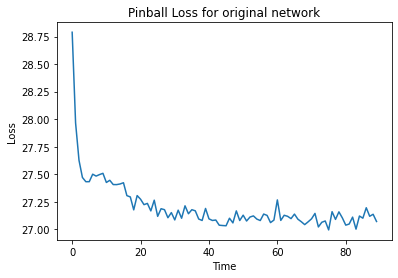

In [0]:
t=list(range(ii+1))

plt.figure()
plt.title('Pinball Loss for original network')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.plot(t,qrlos)

"""
#Experiment for report 1
plt.figure()
plt.title('Binary error')
plt.xlabel('Time')
plt.ylabel('Error %')
plt.plot(t,belos)

plt.figure()
plt.title('MSE loss')
plt.xlabel('Time')
plt.ylabel('Error %')
plt.plot(t,mselos)

plt.figure()
plt.title('L1 loss')
plt.xlabel('Time')
plt.ylabel('Error %')
plt.plot(t,l1los)
"""

plt.show()

In [0]:
#Modified network
def pin_ball_loss(y_true,y_pred):
  qg=(torch.FloatTensor(range(1,100))/100.0).unsqueeze(0).cuda()
  e=(y_true-y_pred).unsqueeze(0)
  temp=torch.cat((qg*e,(qg-1)*e))
  temp=torch.max(temp,dim=0)[0]
  loss=torch.mean(temp)
  return loss

def compute_test_loss(net,test):
  j=0
  loss=0
  for data in test:
    j+=1
    i,p,f=torch.FloatTensor(data['image']).view(-1,3,192,192).cuda(),torch.FloatTensor([data['power']]).cuda(),torch.FloatTensor(data['feats']).view(1,-1).cuda()
    p=p*100
    out=net(i,f)
    loss+=pin_ball_loss(p,out)
  return loss/j

class NewNet(nn.Module):
  def __init__(self):
    super().__init__()
    #Define dissembled operators
    self.dropout = nn.Dropout(p=0.5)
    self.relu=nn.ReLU()
    self.conv1=nn.Conv2d(3,16,7,padding=3)
    self.pool=nn.AvgPool2d(3)
    #AU1
    self.rcu1_conv=nn.Conv2d(16,32,1,2)
    self.rcu1=nn.Sequential(
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,5,padding=2),
        nn.BatchNorm2d(32)
        )
    #AU2
    self.rcu2_conv=nn.Conv2d(32,48,1,2)
    self.rcu2=nn.Sequential(
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48),
        nn.ReLU(),
        nn.Conv2d(48,48,5,padding=2),
        nn.BatchNorm2d(48)
        )
    #AU3
    self.rcu3_conv=nn.Conv2d(48,64,1,2)
    self.rcu3=nn.Sequential(
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,5,padding=2),
        nn.BatchNorm2d(64)
        )
    #AU4
    self.rcu4_conv=nn.Conv2d(64,80,1,2)
    self.rcu4=nn.Sequential(
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,80,5,padding=2),
        nn.BatchNorm2d(80)
        )
    #AU5
    self.rcu5_conv=nn.Conv2d(80,96,1,2)
    self.rcu5=nn.Sequential(
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.Conv2d(96,96,5,padding=2),
        nn.BatchNorm2d(96)
        )
    #FCs
    self.fu=nn.Linear(384,96)
    self.fc0=nn.Linear(96,96)

    
    self.fc1=nn.Linear(4,64)
    self.fc2=nn.Linear(64,96)
    self.fc3=nn.Linear(192,32)
    self.fc4=nn.Linear(32,99)

  def forward(self,au,ef):
    #AU is output from images, EF is output from environment factors

    #Analysis network
    au=self.conv1(au)#1st layer: only conv2d
    au=self.relu(self.rcu1_conv(au)+self.rcu1(self.rcu1_conv(au)))#2nd layer: residual convolution unit
    au=self.relu(self.rcu2_conv(au)+self.rcu2(self.rcu2_conv(au)))#3rd layer: residual convolution unit
    au=self.relu(self.rcu3_conv(au)+self.rcu3(self.rcu3_conv(au)))#4th layer: residual convolution unit
    au=self.relu(self.rcu4_conv(au)+self.rcu4(self.rcu4_conv(au)))#5th layer: residual convolution unit
    au=self.relu(self.rcu5_conv(au)+self.rcu5(self.rcu5_conv(au)))#6th layer: residual convolution unit
    au=self.pool(au)#7th layer: maxpool 2d
    au=au.view(au.shape[0],-1)
    au=self.relu(self.dropout(self.fu(au)))
    au=self.relu(self.dropout(self.fc0(au)))

    #Fully Connect network
    ef=self.relu(self.dropout(self.fc1(ef)))
    ef=self.relu(self.dropout(self.fc2(ef)))
    
    o=torch.cat((ef,au),1)
    o=self.relu(self.dropout(self.fc3(o)))
    o=self.fc4(o)

    return o

In [0]:
#modified network experiment
from tqdm import tqdm
import matplotlib.pyplot as plt

#train Resnet
epochs=90
lr=0.001

pinball_loss=[]
Nnet=NewNet()
Nnet.cuda()
for ii in tqdm(range(epochs)):
  if ii%30==0:
    sgd=torch.optim.SGD(Nnet.parameters(),lr)
    lr=lr*0.1
  Nnet.train()
  for j,data in (enumerate(train_dataloader)):
    i,p,f=data['image'].float().cuda(),data['power'].float().cuda(),data['feats'].float().cuda()
    p=p.view(-1,1)
    pnew=torch.ones((p.shape[0],99),dtype=float).cuda()
    p=p*pnew*100
    sgd.zero_grad()
    out=Nnet(i,f)
    loss=pin_ball_loss(p,out)
    loss.backward()
    sgd.step()
  Nnet.eval()
  with torch.no_grad():
    a=compute_test_loss(Nnet,dev)
    pinball_loss.append(float(a))
    print(a,loss)

with torch.no_grad():
  print("Test loss is: ",float(compute_test_loss(Nnet,test)))

















  0%|          | 0/90 [00:00<?, ?it/s]















  1%|          | 1/90 [01:16<1:53:48, 76.73s/it]

tensor(12.7225, device='cuda:0') tensor(10.8380, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















  2%|▏         | 2/90 [02:33<1:52:31, 76.72s/it]

tensor(9.9337, device='cuda:0') tensor(9.3757, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















  3%|▎         | 3/90 [03:49<1:51:08, 76.65s/it]

tensor(8.7086, device='cuda:0') tensor(7.6338, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















  4%|▍         | 4/90 [05:06<1:49:50, 76.63s/it]

tensor(8.4169, device='cuda:0') tensor(8.2579, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















  6%|▌         | 5/90 [06:22<1:48:22, 76.50s/it]

tensor(8.2758, device='cuda:0') tensor(7.9187, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















  7%|▋         | 6/90 [07:38<1:47:00, 76.44s/it]

tensor(8.1693, device='cuda:0') tensor(7.8042, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















  8%|▊         | 7/90 [08:55<1:45:42, 76.41s/it]

tensor(8.0464, device='cuda:0') tensor(7.6892, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















  9%|▉         | 8/90 [10:11<1:44:15, 76.29s/it]

tensor(7.6410, device='cuda:0') tensor(7.1548, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 10%|█         | 9/90 [11:27<1:42:48, 76.15s/it]

tensor(9.7574, device='cuda:0') tensor(5.0157, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 11%|█         | 10/90 [12:42<1:41:23, 76.04s/it]

tensor(3.8311, device='cuda:0') tensor(3.6165, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 12%|█▏        | 11/90 [13:58<1:40:00, 75.96s/it]

tensor(5.1477, device='cuda:0') tensor(3.2754, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 13%|█▎        | 12/90 [15:14<1:38:42, 75.93s/it]

tensor(5.0724, device='cuda:0') tensor(4.1341, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 14%|█▍        | 13/90 [16:30<1:37:25, 75.91s/it]

tensor(3.0593, device='cuda:0') tensor(4.2086, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 16%|█▌        | 14/90 [17:46<1:36:08, 75.90s/it]

tensor(2.8668, device='cuda:0') tensor(3.4996, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 17%|█▋        | 15/90 [19:02<1:34:52, 75.90s/it]

tensor(2.8562, device='cuda:0') tensor(4.1812, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 18%|█▊        | 16/90 [20:18<1:33:37, 75.91s/it]

tensor(2.9909, device='cuda:0') tensor(4.1375, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 19%|█▉        | 17/90 [21:34<1:32:21, 75.91s/it]

tensor(2.8185, device='cuda:0') tensor(3.3894, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 20%|██        | 18/90 [22:50<1:31:07, 75.93s/it]

tensor(2.5873, device='cuda:0') tensor(2.9466, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 21%|██        | 19/90 [24:05<1:29:50, 75.93s/it]

tensor(2.5922, device='cuda:0') tensor(4.4032, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 22%|██▏       | 20/90 [25:21<1:28:32, 75.89s/it]

tensor(2.8555, device='cuda:0') tensor(2.7254, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 23%|██▎       | 21/90 [26:37<1:27:13, 75.85s/it]

tensor(2.4410, device='cuda:0') tensor(3.2764, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 24%|██▍       | 22/90 [27:53<1:25:57, 75.85s/it]

tensor(2.4853, device='cuda:0') tensor(4.7709, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 26%|██▌       | 23/90 [29:09<1:24:42, 75.85s/it]

tensor(2.5757, device='cuda:0') tensor(3.8656, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 27%|██▋       | 24/90 [30:25<1:23:26, 75.85s/it]

tensor(2.3713, device='cuda:0') tensor(4.4207, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 28%|██▊       | 25/90 [31:40<1:22:08, 75.82s/it]

tensor(2.3869, device='cuda:0') tensor(4.3092, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 29%|██▉       | 26/90 [32:56<1:20:53, 75.84s/it]

tensor(3.0073, device='cuda:0') tensor(3.1059, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 30%|███       | 27/90 [34:12<1:19:38, 75.85s/it]

tensor(2.5313, device='cuda:0') tensor(3.1249, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 31%|███       | 28/90 [35:28<1:18:23, 75.87s/it]

tensor(2.4748, device='cuda:0') tensor(3.4505, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 32%|███▏      | 29/90 [36:44<1:17:07, 75.85s/it]

tensor(2.4115, device='cuda:0') tensor(2.9967, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 33%|███▎      | 30/90 [38:00<1:15:52, 75.88s/it]

tensor(2.5636, device='cuda:0') tensor(3.3700, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 34%|███▍      | 31/90 [39:16<1:14:36, 75.88s/it]

tensor(2.3046, device='cuda:0') tensor(2.4568, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 36%|███▌      | 32/90 [40:32<1:13:20, 75.87s/it]

tensor(2.2628, device='cuda:0') tensor(2.2112, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 37%|███▋      | 33/90 [41:47<1:12:04, 75.86s/it]

tensor(2.2809, device='cuda:0') tensor(4.0811, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 38%|███▊      | 34/90 [43:03<1:10:48, 75.87s/it]

tensor(2.2905, device='cuda:0') tensor(2.5489, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 39%|███▉      | 35/90 [44:19<1:09:32, 75.87s/it]

tensor(2.3277, device='cuda:0') tensor(2.4113, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 40%|████      | 36/90 [45:35<1:08:16, 75.86s/it]

tensor(2.2710, device='cuda:0') tensor(4.1439, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 41%|████      | 37/90 [46:51<1:06:58, 75.81s/it]

tensor(2.2634, device='cuda:0') tensor(3.4596, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 42%|████▏     | 38/90 [48:06<1:05:42, 75.81s/it]

tensor(2.2935, device='cuda:0') tensor(2.2008, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 43%|████▎     | 39/90 [49:22<1:04:26, 75.81s/it]

tensor(2.3157, device='cuda:0') tensor(2.7691, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 44%|████▍     | 40/90 [50:38<1:03:10, 75.80s/it]

tensor(2.2912, device='cuda:0') tensor(3.0950, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 46%|████▌     | 41/90 [51:54<1:01:55, 75.84s/it]

tensor(2.2752, device='cuda:0') tensor(2.5323, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 47%|████▋     | 42/90 [53:11<1:00:54, 76.13s/it]

tensor(2.2882, device='cuda:0') tensor(2.6396, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 48%|████▊     | 43/90 [54:28<59:48, 76.35s/it]  

tensor(2.2845, device='cuda:0') tensor(2.2839, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 49%|████▉     | 44/90 [55:45<58:41, 76.56s/it]

tensor(2.3010, device='cuda:0') tensor(3.1033, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 50%|█████     | 45/90 [57:02<57:32, 76.71s/it]

tensor(2.3116, device='cuda:0') tensor(2.4301, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 51%|█████     | 46/90 [58:19<56:20, 76.83s/it]

tensor(2.3008, device='cuda:0') tensor(2.9892, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 52%|█████▏    | 47/90 [59:36<55:08, 76.94s/it]

tensor(2.3378, device='cuda:0') tensor(2.5816, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 53%|█████▎    | 48/90 [1:00:54<53:58, 77.11s/it]

tensor(2.3055, device='cuda:0') tensor(2.7765, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 54%|█████▍    | 49/90 [1:02:11<52:44, 77.19s/it]

tensor(2.2701, device='cuda:0') tensor(2.8591, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 56%|█████▌    | 50/90 [1:03:28<51:30, 77.26s/it]

tensor(2.3379, device='cuda:0') tensor(2.7698, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 57%|█████▋    | 51/90 [1:04:46<50:14, 77.29s/it]

tensor(2.3171, device='cuda:0') tensor(3.4166, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 58%|█████▊    | 52/90 [1:06:03<48:58, 77.33s/it]

tensor(2.3319, device='cuda:0') tensor(3.0311, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 59%|█████▉    | 53/90 [1:07:21<47:42, 77.36s/it]

tensor(2.3376, device='cuda:0') tensor(2.9559, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 60%|██████    | 54/90 [1:08:38<46:26, 77.42s/it]

tensor(2.3424, device='cuda:0') tensor(3.4817, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 61%|██████    | 55/90 [1:09:56<45:10, 77.45s/it]

tensor(2.3314, device='cuda:0') tensor(3.6334, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 62%|██████▏   | 56/90 [1:11:13<43:54, 77.48s/it]

tensor(2.3222, device='cuda:0') tensor(3.6512, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 63%|██████▎   | 57/90 [1:12:31<42:36, 77.47s/it]

tensor(2.3214, device='cuda:0') tensor(3.1161, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 64%|██████▍   | 58/90 [1:13:48<41:13, 77.30s/it]

tensor(2.3702, device='cuda:0') tensor(2.7081, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 66%|██████▌   | 59/90 [1:15:05<39:53, 77.21s/it]

tensor(2.2881, device='cuda:0') tensor(4.1905, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 67%|██████▋   | 60/90 [1:16:22<38:34, 77.14s/it]

tensor(2.3223, device='cuda:0') tensor(2.8074, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 68%|██████▊   | 61/90 [1:17:38<37:15, 77.09s/it]

tensor(2.3200, device='cuda:0') tensor(3.0451, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 69%|██████▉   | 62/90 [1:18:55<35:56, 77.03s/it]

tensor(2.3312, device='cuda:0') tensor(3.9003, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 70%|███████   | 63/90 [1:20:13<34:40, 77.07s/it]

tensor(2.3205, device='cuda:0') tensor(2.8052, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 71%|███████   | 64/90 [1:21:30<33:22, 77.04s/it]

tensor(2.3274, device='cuda:0') tensor(3.1652, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 72%|███████▏  | 65/90 [1:22:46<32:05, 77.01s/it]

tensor(2.3211, device='cuda:0') tensor(3.3540, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 73%|███████▎  | 66/90 [1:24:03<30:48, 77.01s/it]

tensor(2.3191, device='cuda:0') tensor(2.4127, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 74%|███████▍  | 67/90 [1:25:21<29:31, 77.03s/it]

tensor(2.3283, device='cuda:0') tensor(3.7058, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 76%|███████▌  | 68/90 [1:26:37<28:14, 77.01s/it]

tensor(2.3126, device='cuda:0') tensor(2.4875, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 77%|███████▋  | 69/90 [1:27:55<26:57, 77.03s/it]

tensor(2.3194, device='cuda:0') tensor(2.7214, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 78%|███████▊  | 70/90 [1:29:12<25:41, 77.07s/it]

tensor(2.3255, device='cuda:0') tensor(1.9882, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 79%|███████▉  | 71/90 [1:30:29<24:24, 77.08s/it]

tensor(2.3245, device='cuda:0') tensor(2.4453, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 80%|████████  | 72/90 [1:31:46<23:07, 77.07s/it]

tensor(2.3338, device='cuda:0') tensor(2.4397, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 81%|████████  | 73/90 [1:33:03<21:50, 77.07s/it]

tensor(2.3185, device='cuda:0') tensor(2.2895, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 82%|████████▏ | 74/90 [1:34:20<20:33, 77.12s/it]

tensor(2.3175, device='cuda:0') tensor(2.7289, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 83%|████████▎ | 75/90 [1:35:37<19:16, 77.10s/it]

tensor(2.3247, device='cuda:0') tensor(1.7894, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 84%|████████▍ | 76/90 [1:36:54<17:58, 77.06s/it]

tensor(2.3341, device='cuda:0') tensor(3.0532, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 86%|████████▌ | 77/90 [1:38:11<16:40, 76.93s/it]

tensor(2.3237, device='cuda:0') tensor(3.2786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 87%|████████▋ | 78/90 [1:39:27<15:21, 76.77s/it]

tensor(2.3319, device='cuda:0') tensor(2.6641, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 88%|████████▊ | 79/90 [1:40:43<14:02, 76.61s/it]

tensor(2.3143, device='cuda:0') tensor(2.8014, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 89%|████████▉ | 80/90 [1:42:00<12:44, 76.44s/it]

tensor(2.3385, device='cuda:0') tensor(2.4729, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 90%|█████████ | 81/90 [1:43:16<11:26, 76.32s/it]

tensor(2.3229, device='cuda:0') tensor(2.3529, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 91%|█████████ | 82/90 [1:44:32<10:09, 76.22s/it]

tensor(2.3417, device='cuda:0') tensor(3.0963, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 92%|█████████▏| 83/90 [1:45:48<08:53, 76.18s/it]

tensor(2.3384, device='cuda:0') tensor(2.7895, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 93%|█████████▎| 84/90 [1:47:04<07:36, 76.10s/it]

tensor(2.3437, device='cuda:0') tensor(2.3674, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 94%|█████████▍| 85/90 [1:48:19<06:20, 76.03s/it]

tensor(2.3320, device='cuda:0') tensor(2.1900, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 96%|█████████▌| 86/90 [1:49:35<05:03, 75.98s/it]

tensor(2.3387, device='cuda:0') tensor(2.7521, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 97%|█████████▋| 87/90 [1:50:51<03:47, 75.95s/it]

tensor(2.3256, device='cuda:0') tensor(2.9207, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 98%|█████████▊| 88/90 [1:52:07<02:31, 75.93s/it]

tensor(2.3379, device='cuda:0') tensor(2.8093, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















 99%|█████████▉| 89/90 [1:53:23<01:15, 75.88s/it]

tensor(2.3405, device='cuda:0') tensor(2.5869, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


















100%|██████████| 90/90 [1:54:39<00:00, 76.43s/it]

tensor(2.3418, device='cuda:0') tensor(3.4534, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


Test loss is:  2.3298420906066895


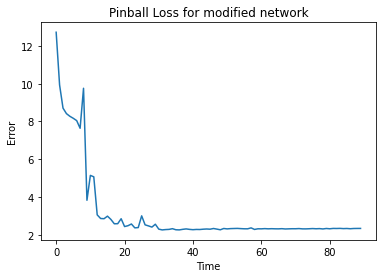

In [0]:
t=list(range(ii+1))
plt.figure()
plt.title('Pinball Loss for modified network')
plt.xlabel('Time')
plt.ylabel('Error')
plt.plot(t,pinball_loss)

plt.show()